# Predicting Course Failure with Decision Trees

For this project, I will take a data set of three years worth of term grades and build a model to predict whether a student is likely to fail a course for the year.

In [2]:
% matplotlib inline
import pandas as pd
import seaborn as sns

sns.set_style('white')

In [3]:
## import data
passfail = pd.read_csv('failureprediction.csv', index_col='studentid')

print len(passfail), 'observations'
passfail.head()

IOError: File projects/failureprediction.csv does not exist

In [166]:
passfail.describe()

,academic_year,att_pct,n_demerits,grade_pct,failed_course
count,40190.000000,40190.000000,40190.000000,40190.000000,40190.000000
mean,2012.171635,90.263896,14.214208,77.035531,0.195944
std,0.797275,11.017330,14.197677,12.945124,0.396931
min,2011.000000,7.000000,1.000000,50.000000,0.000000
25%,2012.000000,86.000000,4.000000,70.000000,0.000000
50%,2012.000000,94.000000,10.000000,78.000000,0.000000
75%,2013.000000,98.000000,19.000000,87.000000,0.000000
max,2013.000000,100.000000,135.000000,111.000000,1.000000


In [1]:
## course number contains some potentially useful information, but it is a hash of subject and course level
## using regex, I'll split it into multiple columns for better analysis
import re    

## create clean df for modifications, dropping any NaN rows
passfail_c = passfail.dropna()

## couldn't figure out how to do this well with one function, so here's two:
def parse_course(coursenum):    
    n = re.split('(\d+)', coursenum)
    course = n[0]
    #level = n[1]
    return course

def parse_level(coursenum):
    import re    
    n = re.split('(\d+)', coursenum)
    level = n[1]
    return level

## create separate columns for each part of the course number
passfail_c['level'] = passfail_c.course_number.apply(parse_level).astype('int')
passfail_c['course'] = passfail_c.course_number.apply(parse_course)

## map dummy values to subjects for use in algorithm
passfail_c['course_dummy'] = passfail_c.course.map({'DRA':0,
                                                    'ENG':1,
                                                    'HIST':2,
                                                    'MATH':3,
                                                    'RHET':4,
                                                    'SCI':5,
                                                    'SPAN':6,
                                                    'GYM':7,
                                                    'ART':8,
                                                    'FREN':9,
                                                    'STUDY':10,
                                                    'WRI':11,
                                                    'THE':12,
                                                    'ARAB':13,
                                                    'BUS':14})

## map integers to term numbers for use in algorithm
passfail_c['term'] = passfail_c.term.map({'Q1':1, 'Q2':2, 'Q3':3, 'Q4':4})

passfail_c.head()

NameError: name 'passfail' is not defined

In [191]:
passfail_sample = passfail_c[passfail_c.academic_year < 2013]
passfail_oos = passfail_c[passfail_c.academic_year == 2013]

# Target

The target, *failed_course*, is a binary variable that indicates whether a student failed a course for the year, represented by a 1 if they failed and a 0 if they passed.

Being able to preict failure can be a very powerful tool for a school with multiple applications:
- Early on in the year, it is important so that the proper interventions can be put in place to minimize the likelyhood of the prediction coming to fruition.
- Later in the year, it's also a important to plan staffing and course offerings for the next year. If a large enough number of students are predicted to fail a course, it will be necessary to have an additional period and teacher to accommodate the students who retake the course the following year.

## Histogram of Passing (0) vs Failing (1) students:

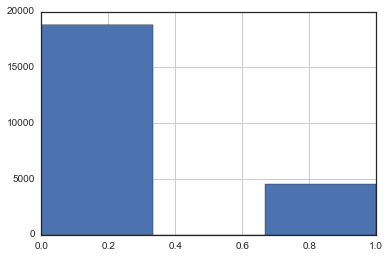

In [192]:
passfail_sample.failed_course.hist(bins=3)

## Histogram of Passing vs Failing students, cut by school year:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000004533D908>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000000458C12E8>], dtype=object)

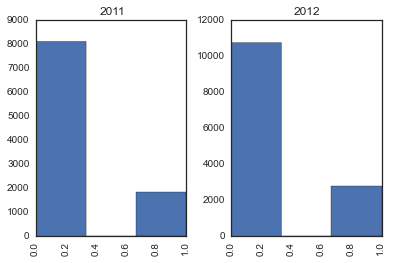

In [193]:
passfail_sample.failed_course.hist(bins=3, by=passfail_sample.academic_year)

# Features

| Feature Name | Description |
|--------------|-------------|
| academic_year | school year during which the observation occurred |
| term | the term for the associated data, there a four quarters in a school year |
| course | the subject of the associated course, derived from *course_number* | 
| level | the level of the associated course, derived from *course_number* |
| grade_pct | a student's grade for the term |
| att_pct | a student's average daily attendance for the term |
| n_demerits | a student's number of behavior infractions for the term |

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000003713CBE0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000040A04518>]], dtype=object)

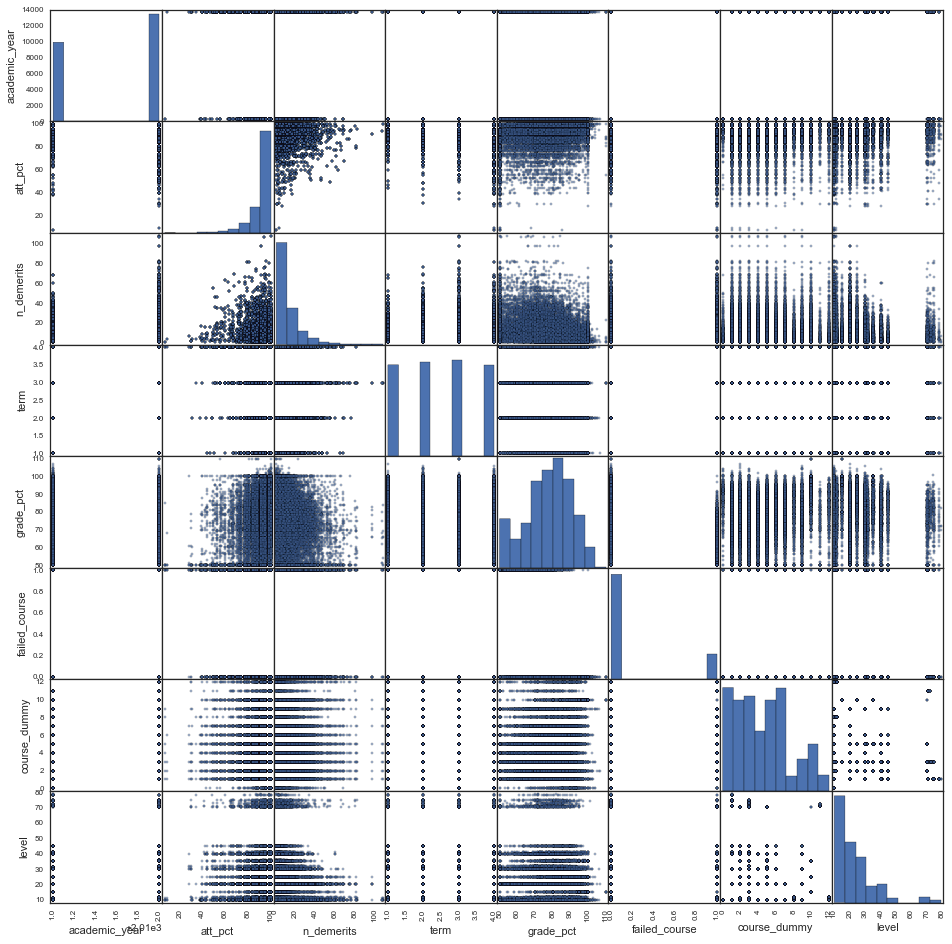

In [171]:
pd.scatter_matrix(passfail_sample, figsize=(16,16))

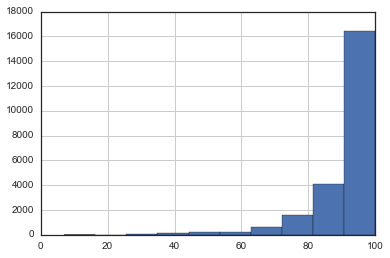

In [172]:
passfail_sample.att_pct.hist()

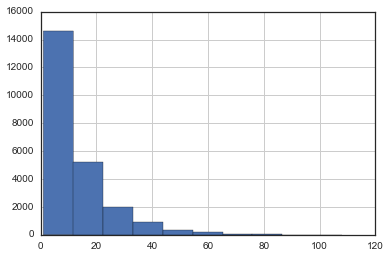

In [173]:
passfail_sample.n_demerits.hist()

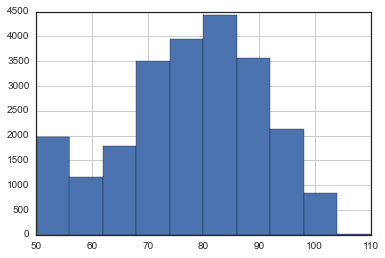

In [174]:
passfail_sample.grade_pct.hist()

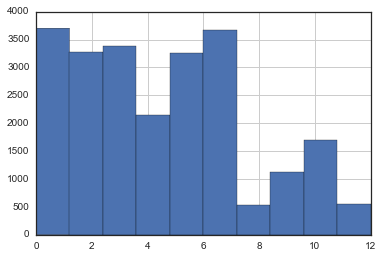

In [175]:
passfail_sample.course_dummy.hist()

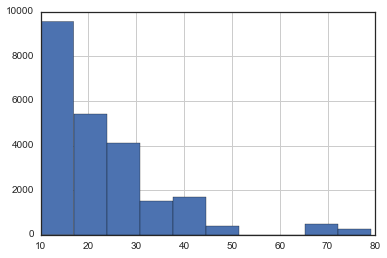

In [176]:
passfail_sample.level.hist()

In [177]:
from sklearn import feature_selection as f_select

features = list(passfail_sample.columns)
features.remove('failed_course') ## target variable
features.remove('academic_year') ## let's see how this performs independent of year
features.remove('course_number') ## split into multiple columns
features.remove('course') ## converted to dummy variable
print 'original feature list:', features

y = passfail_sample.failed_course

significant_features = []
pvals = []
for feature in features:
    pval = f_select.f_classif(passfail_sample[feature], y)
    if pval[1][0] < 0.05:
        significant_features.append(feature)
        pvals.append(pval[1][0])
        
print 'significant features:', significant_features        

X = passfail_sample[significant_features]

original feature list: ['att_pct', 'n_demerits', 'term', 'grade_pct', 'course_dummy', 'level']
significant features: ['att_pct', 'n_demerits', 'grade_pct', 'course_dummy', 'level']


TERM IS NOT SIGNIFICANT

EXPLAIN HOW THESE WILL PREDICT THE TARGET

# Test/Train Split

In [178]:
from sklearn import cross_validation, naive_bayes, tree

def train_and_measure(classifier, x, y):    
    xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=0.2, random_state=1234)
    clf = classifier.fit(xtrain, ytrain)    
    training_accuracy = clf.score(xtrain, ytrain)
    test_accuracy = clf.score(xtest, ytest)
    print classifier
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print

train_and_measure(naive_bayes.MultinomialNB(), X, y)

x_ones = (X > 1) # bernoulli interpretation will only work with 1s and 0s, or binary data.
train_and_measure(naive_bayes.BernoulliNB(), x_ones, y)

train_and_measure(tree.DecisionTreeClassifier(), X, y) ## 100% is suspect but totally possible when a tree has no stopping criteria
train_and_measure(tree.DecisionTreeClassifier(max_depth=10), X, y) ## still does better when stopping criteria is limited

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Accuracy on training data: 0.76
Accuracy on test data:     0.75

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
Accuracy on training data: 0.81
Accuracy on test data:     0.80

DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=1, min_samples_split=2,
            random_state=None, splitter='best')
Accuracy on training data: 1.00
Accuracy on test data:     0.83

DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=1, min_samples_split=2,
            random_state=None, splitter='best')
Accuracy on training data: 0.91
Accuracy on test data:     0.87



# Model Building

Best score: 0.916555035917
5


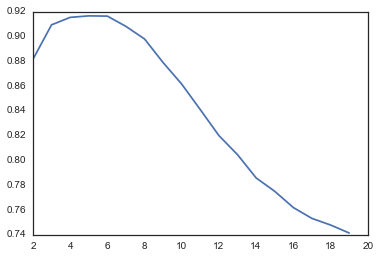

In [179]:
from sklearn.cross_validation import cross_val_score
from matplotlib import pyplot as plt

all_scores = []
best_score = -1
max_param = 20
for param in range(2, max_param):    
    scores = cross_val_score(tree.DecisionTreeClassifier(max_depth=param, random_state=1234),
                                 X,
                                 y,
                                 scoring='roc_auc',
                                 cv=5)
    if scores.mean() > best_score:
        best_param = param
        best_score = scores.mean()
    all_scores.append(scores.mean())

print 'Best score:', best_score
print best_param

plt.figure()
plt.plot(range(2, max_param), all_scores)

In [180]:
treeclf = tree.DecisionTreeClassifier(max_depth=5, random_state=1234).fit(X, y)

In [181]:
# compute the feature importances
pd.DataFrame({'feature':significant_features, 'importance':treeclf.feature_importances_})

,feature,importance
0,att_pct,0.006144
1,n_demerits,0.004922
2,grade_pct,0.966963
3,course_dummy,0.003182
4,level,0.018789


# Model Scoring

false positive rate: 0.0463460005315
true positive rate: 0.605349704012
accuracy: 0.885694729637
AUC score: 0.77950185174


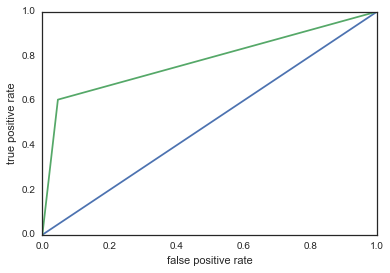

In [182]:
from sklearn import metrics

print 'false positive rate:', metrics.roc_curve(y, treeclf.predict(X))[0][1]
print 'true positive rate:', metrics.roc_curve(y, treeclf.predict(X))[1][1]
print 'accuracy:', metrics.accuracy_score(y, treeclf.predict(X))

roc = metrics.roc_curve(y, treeclf.predict(X))

plt.figure()
plt.plot([0, 0.5, 1], [0, 0.5, 1])
plt.plot(roc[0], roc[1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

auc = metrics.roc_auc_score(y, treeclf.predict(X))
print 'AUC score:', auc

EXPLAIN SCORE RESULTS

# Predict

In [183]:
X_oos = passfail_oos[significant_features]
y_oos = passfail_oos.failed_course

false positive rate: 0.0507407407407
true positive rate: 0.635787567894
accuracy: 0.887474723445
AUC score: 0.792523413577


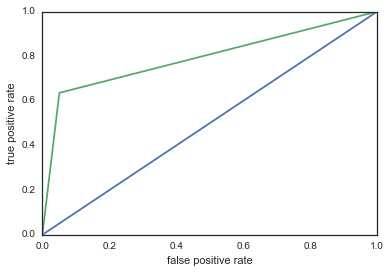

In [184]:
print 'false positive rate:', metrics.roc_curve(y_oos, treeclf.predict(X_oos))[0][1]
print 'true positive rate:', metrics.roc_curve(y_oos, treeclf.predict(X_oos))[1][1]
print 'accuracy:', metrics.accuracy_score(y_oos, treeclf.predict(X_oos))

roc = metrics.roc_curve(y_oos, treeclf.predict(X_oos))

plt.figure()
plt.plot([0, 0.5, 1], [0, 0.5, 1])
plt.plot(roc[0], roc[1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

auc = metrics.roc_auc_score(y_oos, treeclf.predict(X_oos))
print 'AUC score:', auc

In [185]:
passfail2014 = pd.read_csv('projects/failureprediction2014.csv', index_col='studentid')

import re    

def parse_course(coursenum):    
    n = re.split('(\d+)', coursenum)
    course = n[0]    
    return course

def parse_level(coursenum):
    import re    
    n = re.split('(\d+)', coursenum)
    level = n[1]
    return level

passfail2014['term'] = passfail2014.term.map({'Q1':1, 'Q2':2, 'Q3':3, 'Q4':4})

passfail2014['course'] = passfail2014.course_number.apply(parse_course)
passfail2014['course_dummy'] = passfail2014.course.map({'DRA':0,
                                                  'ENG':1,
                                                  'HIST':2,
                                                  'MATH':3,
                                                  'RHET':4,
                                                  'SCI':5,
                                                  'SPAN':6,
                                                  'GYM':7,
                                                  'ART':8,
                                                  'FREN':9,
                                                  'STUDY':10,
                                                  'WRI':11,
                                                  'THE':12,
                                                  'ARAB':13,
                                                  'BUS':14})

passfail2014['level'] = passfail2014.course_number.apply(parse_level).astype('int')

passfail2014.describe()

,academic_year,att_pct,n_demerits,term,grade_pct,failed_course,course_dummy,level
count,9325,9325.000000,9325.000000,9325.000000,9325.000000,0,9325.000000,9325.000000
mean,2014,91.593351,21.907024,1.501019,78.437705,NaN,4.211367,22.252976
std,0,9.093230,18.583084,0.500026,13.517090,NaN,3.005686,15.933757
min,2014,26.000000,1.000000,1.000000,50.000000,NaN,1.000000,1.000000
25%,2014,88.000000,8.000000,1.000000,71.000000,NaN,2.000000,10.000000
50%,2014,94.000000,17.000000,2.000000,80.000000,NaN,3.000000,20.000000
75%,2014,98.000000,31.000000,2.000000,88.000000,NaN,6.000000,30.000000
max,2014,100.000000,118.000000,2.000000,219.000000,NaN,13.000000,78.000000


   failed_course  studentid
0              0        525
1              0        525
2              0        525
3              0        525
4              1        525


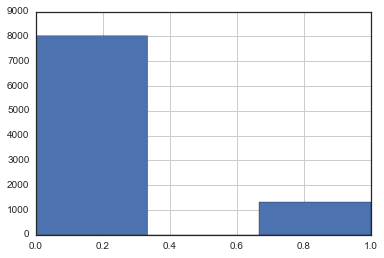

In [186]:
X_curr = passfail2014[significant_features]
y_pred = treeclf.predict(X_curr)

predictions = pd.DataFrame({'studentid':passfail2014.index, 'failed_course':y_pred})
print predictions.head()
predictions.failed_course.hist(bins=3)

# Results Summary